<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Text Classification

Text classification is one of the most common tasks in NLP and can be used for applications
such as tagging customer feedback into categories or routing support tickets according to their
language. Chances are that your email’s spam filter is using text classification to protect your
inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which aims to identify the
polarity of a given text.

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express towards your company’s
product on Twitter. 

Until 2018, the deep learning approach to this problem typically involved
finding a suitable neural architecture for the task and training it from scratch on a dataset of
labeled tweets. This approach suffered from three major drawbacks:

- You needed a lot of labeled data to train accurate models like recurrent or
convolutional neural networks.
- Training these models from scratch was time consuming and expensive.
- The trained model could not be easily adapted to a new task, e.g. with a different set of labels.

Nowadays, these limitations are largely overcome via transfer learning, where typically a
Transformer-based architecture is pretrained on a generic task such as language modeling and
then reused for a wide variety of downstream tasks.

##Setup

In [1]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

     |████████████████████████████████| 3.3 MB 5.2 MB/s 
     |████████████████████████████████| 61 kB 480 kB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 3.3 MB 34.7 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 39.0 MB/s 
     |████████████████████████████████| 298 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 50.5 MB/s 
     |████████████████████████████████| 243 kB 45.7 MB/s 
     |████████████████████████████████| 1.1 MB 34.8 MB/s 
     |████████████████████████████████| 271 kB 40.8 MB/s 
     |████████████████████████████████| 160 kB 49.8 MB/s 
     |████████████████████████████████| 192 kB 39.4 MB/s 


In [24]:
from transformers import pipeline
from transformers import set_seed
from datasets import list_datasets, load_dataset

import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##The Dataset

To build our emotion detector we’ll use a great dataset from an article that explored how
emotions are represented in English Twitter messages. 

Unlike most sentiment analysis datasets
that involve just “positive” and “negative” polarities, this dataset contains six basic emotions:
anger, disgust, fear, joy, sadness, and surprise. 


Given a tweet, our task will be to train a model
that can classify it into one of these emotions!

###Overview of Datasets

In [3]:
# We can use the list_datasets function to see what datasets are available in the Hub:
datasets = list_datasets()

print(f"There are {len(datasets)} datasets currently available on the Hub.")
print(f"The first 10 are: {datasets[:10]}")

There are 2147 datasets currently available on the Hub.
The first 10 are: ['0n1xus/codexglue', '0n1xus/pytorrent-standalone', 'AConsApart/anime_subtitles_DialoGPT', 'AI-Sweden/SuperLim', 'ARKseal/YFCC14M_subset_webdataset', 'ARTeLab/fanpage', 'ARTeLab/ilpost', 'ARTeLab/mlsum-it', 'Abdo1Kamr/Arabic_Hadith', 'Abirate/english_quotes']


We see that each dataset is given a name, so let’s inspect the metadata associated with the
emotion dataset:

In [4]:
metadata = list_datasets(with_details=True)[datasets.index("emotion")]

# Show dataset description
print("Description:", metadata.description, "\n")
# Show first 8 lines of the citation string
print("Citation:", "\n".join(metadata.citation.split("\n")[:8]))

Description: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper. 

Citation: @inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing",


This looks like the dataset we’re after, so next we can load it with the `load_dataset` function from Datasets:

In [5]:
emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. 

And just like any dictionary, we can access an individual split as usual

In [7]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

This object behaves like an
ordinary Python container, so we can query its length

In [8]:
len(train_ds)

16000

or access a single example by its index

In [9]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Here we see that a single row is represented as a
dictionary, where the keys correspond to the column names

In [10]:
train_ds.column_names

['text', 'label']

This reflects the fact that Datasets is
based on Apache Arrow, which defines a typed columnar format that is more memory efficient
than native Python. 

We can see what data types are being used under the hood by accessing the
features attribute of a Dataset object:

In [11]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

We can also access several rows with a slice

In [12]:
train_ds[:6]

{'label': [0, 0, 3, 2, 3, 0],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was']}

or get the full column by name

In [13]:
train_ds["text"][:6]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was']

In each case the resulting data structure depends on the type of query; although this may feel
strange at first, it’s part of the secret sauce that makes Datasets so flexible!

###From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often
convenient to convert a Dataset object to a Pandas DataFrame so we can access highlevel
APIs for data visualization. 

To enable the conversion, Datasets provides a
`Dataset.set_format` function that allow us to change the output format of the Dataset.

This does not change the underlying data format which is Apache Arrow and you can switch to
another format later if needed:

In [14]:
emotions.set_format(type="pandas")

df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As we can see, the column headers have been preserved and the first few rows match our
previous views of the data. 

However, the labels are represented as integers so let’s use the
`ClassLabel.int2str` function to create a new column in our DataFrame with the
corresponding label names:

In [15]:
def label_int2str(row, split):
  return emotions[split].features["label"].int2str(row)

In [16]:
df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


###Look at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the
distribution of examples among each class. 

For example, a dataset with a skewed class
distribution might require a different treatment in terms of the training loss and evaluation
metrics than a balanced one.

With Pandas and the visualisation library Matplotlib we can quickly visualize this as follows:

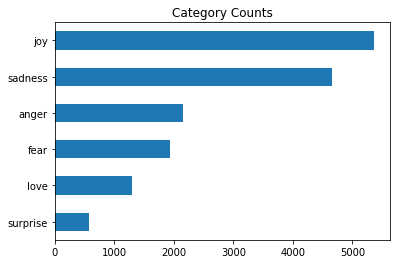

In [17]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

We can see that the dataset is heavily imbalanced; the joy and sadness classes appear
frequently whereas love and sadness are about 5-10 times rarer.

There are several ways to
deal with imbalanced data such as resampling the minority or majority classes.

Alternatively, we can also weight the loss function to account for the underrepresented classes.

###How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the maximum context size. 

For most applications with BERT, the maximum context size is 512 tokens, where
a token is defined by the choice of tokenizer and can be a word, subword, or character. 

Let’s make a rough estimate of our tweet lengths per emotion by looking at the distribution of words per tweet:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


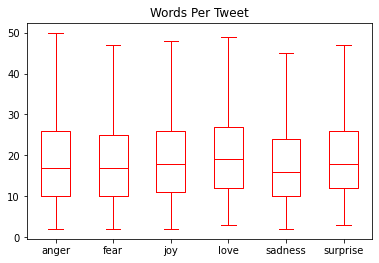

In [18]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="red", )
plt.suptitle("")
plt.xlabel("");

From the plot we see that for each emotion, most tweets are around 15 words long and the
longest tweets are well below BERT’s maximum context size of 512 tokens. 

Texts that are
longer than a model’s context window need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information. 

Let’s now figure out how we can
convert these raw texts into a format suitable for Transformers!

##Tokenization

Transformer models like BERT cannot receive raw strings as input; instead they assume the
text has been tokenized into numerical vectors. Tokenization is the step of breaking down a
string into the atomic units used in the model. 

There are several tokenization strategies one can
adopt and the optimal splitting of words in sub-units is usually learned from the corpus.

Before
looking at the tokenizer used for BERT, let’s motivate it by looking at two extreme cases:
character and word tokenizers.

###Character Tokenization

The simplest tokenization scheme is to feed each character individually to the model. 

In Python, str objects are really arrays under the hood which allows us to quickly implement character-level tokenization with just one line of code:

In [19]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a good start but we are not yet done because our model expects each character to be
converted to an integer, a process called numericalization. 

One simple way to do this is by
encoding each unique token (which are characters in this case) with a unique integer:

In [20]:
token2idx = {}
for idx, unique_char in enumerate(set(tokenized_text)):
  token2idx[unique_char] = idx

print(token2idx)

{'.': 0, 'n': 1, 'e': 2, 'f': 3, 'L': 4, ' ': 5, 's': 6, 'c': 7, 'g': 8, 'a': 9, 'P': 10, 'i': 11, 'N': 12, 'r': 13, 'z': 14, 'k': 15, 't': 16, 'o': 17, 'T': 18, 'x': 19}


In [22]:
token2idx["e"]

2

In [23]:
token2idx["c"]

7

This gives us a mapping from each character in our vocabulary to a unique integer, so we can
now use token2idx to transform the tokenized text to a list of integers:

In [30]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[18, 17, 15, 2, 1, 11, 14, 11, 1, 8, 5, 16, 2, 19, 16, 5, 11, 6, 5, 9, 5, 7, 17, 13, 2, 5, 16, 9, 6, 15, 5, 17, 3, 5, 12, 4, 10, 0]


We are almost done! Each token has been mapped to a unique, numerical identifier, hence the name `input_ids`.

The last step is to convert `input_ids` into a 2d tensor of one-hot vectors
which are better suited for neural networks than the categorical representation of `input_ids`.

The reason for this is that the elements of `input_ids` create an ordinal scale, so adding or subtracting two IDs is a meaningless operation since the result in a new ID that represents another random token.

On the other hand, the result of the adding two one-hot encodings can be
easily interpreted: the two entries that are “hot” indicate that the corresponding two tokens cooccur.
Each one-hot vector will have a length the size of the vocabulary and a “1” entry at the
position of each ID, with zeros everywhere else.

We can do this directly in PyTorch by converting `input_ids` to a `torch.Tensor`:

In [25]:
input_ids = torch.tensor(input_ids)

one_hot_encodings = torch.nn.functional.one_hot(input_ids)
one_hot_encodings.shape

torch.Size([38, 20])

For each of the 38 input tokens we now have a one-hot vector of dimension 20 since our vocabularly consists of 20 unique characters.

By examining the first vector, we can verify that a
1 appears in the location indicated by `input_ids[0]`:

In [32]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot vector: {one_hot_encodings[0]}")

Token: T
Tensor index: 18
One-hot vector: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


In [33]:
print(f"Token: {tokenized_text[3]}")
print(f"Tensor index: {input_ids[3]}")
print(f"One-hot vector: {one_hot_encodings[3]}")

Token: e
Tensor index: 2
One-hot vector: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example, we can see that character-level tokenization ignores any structure in the texts such as words and treats them just as streams of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words
need to be learned, and that process requires significant compute and memory.

For this reason, character tokenization is rarely used in practice. Instead, some structure of the text such as
words is preserved during the tokenization step.

###Word Tokenization